In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import scipy
import scipy.spatial as sp
import matplotlib
from matplotlib import pyplot as plt
import json
from importlib import reload
import itertools
# local
# import utils
# reload(utils)
# from utils import *

In [30]:
left_im, middle_im, right_im = [sk.img_as_float(skio.imread(f'data/{im}.jpg')) for im in ('left', 'middle', 'right')]
assert left_im.shape == middle_im.shape == right_im.shape

In [3]:
def align_two(a, b, N):
    def prompt(im):
        %matplotlib qt
        plt.imshow(im)
        r = plt.ginput(n=1)
        plt.close()
        return r[0]
        %matplotlib inline

    return [(prompt(a), prompt(b)) for _ in range(N)]

In [209]:
left_middle_align = None
%store -r left_middle_align
if left_middle_align is None:
    left_middle_align = align_two(left_im, middle_im, N=8)
    %store left_middle_align

Stored 'left_middle_align' (list)


In [9]:
middle_right_align = None
%store -r middle_right_align
if middle_right_align is None:
    middle_right_align = align_two(right_im, middle_im, N=8)
    %store middle_right_align

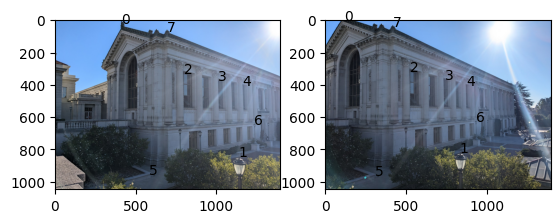

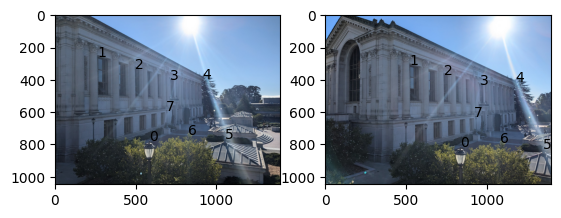

In [306]:
def display_alignment(a, b, alignment):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(a)
    ax2.imshow(b)
    for n, (a_xy, b_xy) in enumerate(alignment):
        ax1.text(*a_xy, n)
        ax2.text(*b_xy, n)

%matplotlib inline
display_alignment(left_im, middle_im, left_middle_align)
plt.show()
display_alignment(right_im, middle_im, middle_right_align)
plt.show()

In [219]:
coords_yx = [['y_1', 'x_1'], ['y_2', 'x_2'], ['y_3', 'x_3']]
print(coords_yx)
print(np.array(coords_yx))
print(np.array(coords_yx).T)

[['y_1', 'x_1'], ['y_2', 'x_2'], ['y_3', 'x_3']]
[['y_1' 'x_1']
 ['y_2' 'x_2']
 ['y_3' 'x_3']]
[['y_1' 'y_2' 'y_3']
 ['x_1' 'x_2' 'x_3']]


In [211]:
def compute_H(correspondences):
    # We want to solve Ah=b using least squares.
    # i.e. min ||Ah - b||^2.
    # Where A = left pts, b = right pts, and h = entries of H.
    # Len(h) = 8, as perspective has 8 unknowns. 
    # Note that H is h reshaped into (3, 3), with H[2,2] = 1.
    # Labelling h = [a, b, c ... , h],
    # solving Hp = p' (where p, p' is a pt correspondence) yields:
    #   a b c d e f   g     h
    # [ x y 1 0 0 0 -x*x' -y*x' ] h = [ x' ]
    # [ 0 0 0 x y 1 -x*y' -y*y' ]     [ y' ]
    #             A                     b
    # We can stack A and b for redundancy.

    rows = [((x, y, 1, 0, 0, 0, -x * x_prime, -y * y_prime), 
             (0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime)) for ((x, y), (x_prime, y_prime)) in correspondences]
    A = np.vstack(rows)
    b = np.vstack([np.vstack((x_prime, y_prime)) for (_, (x_prime, y_prime)) in correspondences])

    h, _, _ ,_ = np.linalg.lstsq(A, b)
    H = (np.vstack((h, 1)).reshape((3, 3)))
    return H

left_to_middle_H = compute_H(left_middle_align)
right_to_middle_H = compute_H(middle_right_align)

In [331]:
def apply_affine(A, b):
    c = A @ np.vstack((b, np.ones(len(b[0]))))
    return np.array((c[0] / c[2], c[1] / c[2]))

def box(mins, maxs):
    return np.array(((mins[1], mins[0]), (maxs[1], mins[0]), (maxs[1], maxs[0]), (mins[1], maxs[0]))).T
    
def translate_coords(b, offset):
    return b + offset[::-1][..., None]
    
def bounding_boxes(im, H):
    bbox = box((0, 0), im.shape[:2])
    warped_bbox = apply_affine(H, bbox)
    min_c, max_c = np.min((*bbox[0], *warped_bbox[0])), np.max((*bbox[0], *warped_bbox[0]))
    min_r, max_r = np.min((*bbox[1], *warped_bbox[1])), np.max((*bbox[1], *warped_bbox[1]))
    containing_bbox = box((min_r, min_c), (max_r, max_c))
    offset = -1 * np.array((min_r, min_c))
    return offset, translate_coords(bbox, offset), translate_coords(warped_bbox, offset), translate_coords(containing_bbox, offset)

def set_im(im, offset=(0, 0), new_shape=None):
    offset = offset.astype(int)
    if new_shape == None:
        new_shape = (im.shape[0] + offset[0], im.shape[1] + offset[1], 3)
    new_im = np.zeros(new_shape)
    new_im[offset[0]:offset[0]+im.shape[0],offset[1]:offset[1]+im.shape[1]] = im
    return new_im

def shape_from_bbox(bbox):
    return (int(np.max(bbox[1])), int(np.max(bbox[0])), 3)

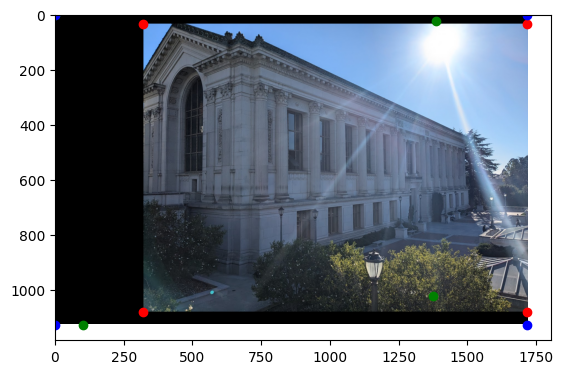

In [271]:
offset, bbox, warped_bbox, containing_bbox = bounding_boxes(middle_im, left_to_middle_H)
plt.imshow(set_im(middle_im, offset, shape_from_bbox(containing_bbox)))
plt.plot(*bbox, 'ro')
plt.plot(*warped_bbox, 'go')
plt.plot(*containing_bbox, 'bo')
plt.show()

In [328]:
def interpolate(src, pts, method='nearest'):
    x, y = np.meshgrid(np.arange(src.shape[1]), np.arange(src.shape[0]))
    grid_points = np.column_stack((y.flatten(), x.flatten()))
    return np.dstack([scipy.interpolate.griddata(grid_points, src[:,:,i].flatten(), pts, method) for i in range(3)])

def warp_im(im, H):
    offset, bbox, warped_bbox, containing_bbox = bounding_boxes(im, H)
    final_shape = shape_from_bbox(containing_bbox)
    src = set_im(im, offset, final_shape)
    dest = np.zeros(final_shape)

    warped_polygon = sk.draw.polygon(warped_bbox[1] - 1, warped_bbox[0] - 1)

    H_inv = np.linalg.inv(H)
    bound = lambda mask, shape: (np.clip(mask[1], 0, shape[0] - 1), np.clip(mask[0], 0, shape[1] - 1), )
    pts = bound(apply_affine(H_inv, warped_polygon[::-1]), final_shape)
    dest[warped_polygon] = interpolate(src, pts)
    
    return dest

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


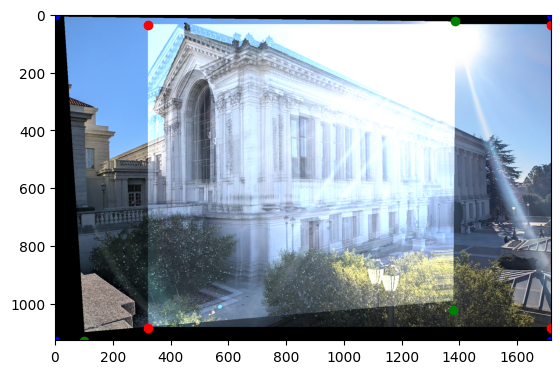

In [329]:
offset, bbox, warped_bbox, containing_bbox = bounding_boxes(middle_im, left_to_middle_H)
plt.plot(*bbox, 'ro')
plt.plot(*warped_bbox, 'go')
plt.plot(*containing_bbox, 'bo')
plt.imshow(warp_im(left_im, left_to_middle_H) + set_im(middle_im, offset, shape_from_bbox(containing_bbox)))
plt.show()

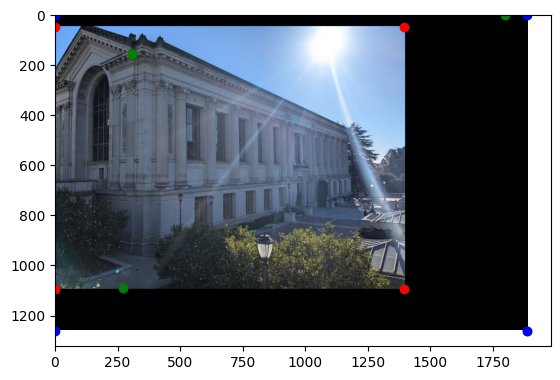

In [333]:
r_offset, r_bbox, r_warped_bbox, r_containing_bbox = bounding_boxes(middle_im, right_to_middle_H)
plt.imshow(set_im(middle_im, r_offset, shape_from_bbox(r_containing_bbox)))
plt.plot(*r_bbox, 'ro')
plt.plot(*r_warped_bbox, 'go')
plt.plot(*r_containing_bbox, 'bo')
plt.show()